In [ ]:
### Importing Reqired Libraries
import os
import cv2
import time
import pickle
import string
import operator
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms
from torchtext.data.metrics import bleu_score
from torchtext.data.utils import get_tokenizer

from PIL import Image
from tqdm import tqdm
from collections import Counter
from queue import PriorityQueue

from matplotlib import pyplot as plt
#matplotlib inline

Extracting Image features from pre-trained CNN

In [ ]:
#To use GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Helper Function - for resigtering forward hooks, retrives activation of specified layer
def get_activation(name, _dict):
    """
    Input:
            - name: name of the layer whose activations you want to retrive
    Output:
            - hook: returns a forward hook to the specified layer
    """

    def hook(model, input, output):
        _dict[name] = output.detach()

    return hook

In [ ]:
### Helper Function - for applying transforms to image
def get_transforms():

    # Values for each channel (RGB) for normalizing
    normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

    # Convert image to tensor and normalize
    return transforms.Compose([transforms.ToTensor(), normalize])

In [ ]:
# A Function that extracts features from images
def extract_features(path, model, transforms):
    """
    Input:
            - path: path to directory where all the images are stored
            - model: pre-trained CNN model, that will be used as feature extractor
    Output:
            - dict: {image_name: feature_vector}
    """
    # Register a forward hook to the layer that outputs a feature vector - we are using Inception V3, and feature vector is returned by Mixed_7c layer
    activation = {}
    model.Mixed_7c.register_forward_hook(get_activation(name = "Mixed_7c", _dict = activation))

    # Pooling Function
    pool = nn.AdaptiveAvgPool2d((1, 1))

    # Dict to store features
    image_features = {}

    # Iterate through all images, extract features, store it in dict
    for file in tqdm(os.listdir(path)):
        img_name = file.split('.')[0]
        img_path = path + '/' + file

        # Load and re-size the image
        img = Image.open(img_path)
        img = img.resize((299, 299))

        # Pre-process the image, apply transforms
        img_tensor = transforms(img)
        img_tensor = torch.unsqueeze(img_tensor, dim = 0)

        # Forward prop image through model to extract features
        img_tensor = img_tensor.to(device)
        output = model(img_tensor)
        features = activation["Mixed_7c"]
        # Get 2048 dim feature vector by applying pooling
        features = pool(features)
        features = torch.squeeze(features).cpu().numpy()

        # Add image name and feature vector to dict
        image_features[img_name] = features

    return image_features

In [ ]:
### Creating an instance of pre-trained InceptionV3 - feature extractor
inception_v3 = models.inception_v3(pretrained = True)

### Set model to evaluation mode and load to device
inception_v3.eval()
inception_v3.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 178MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Fetch the dataset

In [ ]:
#Using Kaggle dataset
from google.colab import files

# Choose the file from your system to upload
uploaded = files.upload()

# Move the uploaded file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d jainamshah17/flicker8k-image-captioning

100% 1.16G/1.16G [00:56<00:00, 24.0MB/s]
100% 1.16G/1.16G [00:56<00:00, 22.0MB/s]


In [ ]:
import zipfile
import os

# To unzip the dataset
zip_file_path = 'flicker8k-image-captioning.zip'
destination_folder = 'PICT'  # desired folder name

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print("Dataset has been unzipped to:", destination_folder)

Dataset has been unzipped to: PICT


In [ ]:
# To check destination of folder
destination_folder = 'PICT'

# Get the absolute path of the destination folder
destination_folder_path = os.path.abspath(destination_folder)

print("Destination folder path:", destination_folder_path)

Destination folder path: /content/PICT


In [ ]:
### Specify path to directory where all the images are stored
images_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset"

### Extract image features by calling 'extract_features' function
image_features = extract_features(path = images_path, model = inception_v3, transforms = get_transforms())

100%|██████████| 8091/8091 [03:28<00:00, 38.80it/s]


Pre-processing Captions, building Vocabulary (word map)

In [ ]:
### Helper function - for loading captions from txt file
def load_captions(path):
    """
    Input:
            - path: path to .txt file in which captions are stored
    Output:
            - list: a list of all captions
    """

    # A list & dict to store all captions for image
    captions_list = []
    image_captions = {}
    # Open the file containing captions
    with open(path, "r") as file:

        #Iterate through each line, append each caption to the list
        for line in file.readlines():

            # Extract caption by splitting the line into words
            words = line.strip("\n").split()

            # Join the words to form a caption, append to the list
            caption = ' '.join(words[1:])
            captions_list.append(caption)

    return captions_list

In [ ]:
### Helper Function - removing punctuation, tokenizing caption
def preprocess_caption(caption):
    """
    Input:
            - caption: raw caption to pre-process
    Output:
            - list: list of tokens; tokenized caption
    """

    # Tokenizer - it will automatically convert words to lower case and tokenize them
    tokenizer = get_tokenizer("basic_english")

    # Removing punctuations from caption
    caption = "".join([char for char in caption if char not in string.punctuation])
         # Tokenizing caption
    tokenized_caption = tokenizer(caption)

    return tokenized_caption

In [ ]:
### Helper Function - to build a vocabulary, we will apply all basic pre-processing here such as lower case, removing punctuation, tokenization, etc.
def build_vocabulary(captions_list, min_freq = 5):
    """
    Input:
            - list: a list containing all captions
            - min_freq: minimum count of a word to be part of the vocabulary
    Output:
            - dict: word mapping / vocabulary
    """
    # Frequency counter
    word_freq = Counter()

    # Pre-process the caption and update the frequency counter
    for caption in captions_list:

        # Preprocessing caption
        tokenized_caption = preprocess_caption(caption)

        # Update freq count
        word_freq.update(tokenized_caption)
    # Create word mapping / vocabulary
    words = [w for w in word_freq.keys() if word_freq[w] >= min_freq]
    word_map = {k: v + 1 for v, k in enumerate(words)}
    word_map['<unk>'] = len(word_map) + 1
    word_map['<start>'] = len(word_map) + 1
    word_map['<end>'] = len(word_map) + 1
    word_map['<pad>'] = 0

    return word_map

In [ ]:
### Load Captions from given .txt file
tokens_path = "/content/PICT/Flickr8k_text/Flickr8k.token.txt"
captions_list = load_captions(path = tokens_path)

### Build Vocabulary from captions
word_map = build_vocabulary(captions_list = captions_list, min_freq = 5)

In [ ]:
### Dump vocabulary into a pickle file for future use
pickle.dump(word_map, open('word_map_min5.pkl', 'wb'))

Creating train / val / test files to directly use for data loaders

In [ ]:
### Helper Function - to create seperate file containing img - caption for given img list
def split_data(all_captions_path, img_list_path, name):
    """
    Input:
            - all_captions_path: path to .txt file containing all img - captions
            - img_list_path: path to .txt file containing images list
            - name: name to store the new .txt file containing image and caption Ex; train / dev / test
    """

    # Temp List to store all img names
    img_names = []
    # Extract Images Names from given file
    with open(img_list_path, "r") as file:

        # Iterate through each line, append each image to the list
        for line in file.readlines():

            # Get image name by reading lines, append it to the list
            img_name = line.strip("\n").split(".")[0]
            img_names.append(img_name)

    # Temp List to store lines for new file: img_name caption
    lines = []

    # Extract captions for images in temp img list
    with open(all_captions_path, "r") as file:
      # Iterate through each line and compare image name
        for line in file.readlines():

            # Get image name
            words = line.strip("\n").split()
            img_name = words[0].split(".")[0]

            if img_name in img_names:
                new_line = img_name + " " + " ".join(words[1:])
                lines.append(new_line)

    # Create new .txt file with given name
    with open(name + ".txt", "w") as file:
        # Write all lines to new txt file
        lines = map(lambda x:x + '\n', lines)
        file.writelines(lines)


In [ ]:
### Splitting the data as per the given files
all_captions_path = "/content/PICT/Flickr8k_text/Flickr8k.token.txt"
train_list_path = "/content/PICT/Flickr8k_text/Flickr_8k.trainImages.txt"
dev_list_path = "/content/PICT/Flickr8k_text/Flickr_8k.devImages.txt"
test_list_path = "/content/PICT/Flickr8k_text/Flickr_8k.testImages.txt"

# Creating train.txt
split_data(all_captions_path, train_list_path, "train")

# Creating dev.txt
split_data(all_captions_path, dev_list_path, "dev")

# Creating test.txt
split_data(all_captions_path, test_list_path, "test")

Preparing Dataset and Data Loaders for Model

In [ ]:
### Helper Function - to convert raw captions to vectors; preprocess, apply word mapping, pad with zeros
def caption_to_vectors(caption, word_map, max_length):
    """
        Input:
                - caption: caption to process
                - word_map: vocabulary / dict containing mapping of all words to no
                - max_length: maximum length of sentence / caption
        Output:
                - _input: input vector
                - _output: output vector
    """
 # Pre-process caption
    caption = preprocess_caption(caption)

    # Append start token
    caption.insert(0, "<start>")

    # Create input and output words
    input_words = caption
    output_words = caption[1:]
    output_words.append("<end>")
  # Apply word mapping
    input_map = [word_map[k] if k in word_map.keys() else word_map["<unk>"] for k in input_words ]
    output_map = [word_map[k] if k in word_map.keys() else word_map["<unk>"] for k in output_words ]

    # Vectors of size max_len - used for 0 padding
    input_vector = np.zeros(max_length, dtype = np.int_)
    output_vector = np.zeros(max_length, dtype = np.int_)

    for i in range(len(input_map)):
        input_vector[i] = input_map[i]
        output_vector[i] = output_map[i]
    return input_vector, output_vector

In [ ]:
### Overriding Dataset Class
class NICDataset(Dataset):

    def __init__(self, data_path, image_features_path, word_map_path, max_length = 40):
        """
            Input:
                    - data_path: path to .txt file which contains img name caption
                    - image_features_path: path to the pkl file in which image_features dict is stored
                    - word_map_path: path to pkl file in which word mapping / vocabulary is stored
                    - max_length: maximum length of sentence
        """
        super().__init__()
        self.data_list = []
        self.image_features = pickle.load(open(image_features_path, "rb"))
        self.word_map = pickle.load(open(word_map_path, "rb"))
        self.max_length = max_length

        # Initialize data_list by reading .txt file from data path
        with open(data_path, "r") as file:

            #Iterate through each line to extract image names
            for line in file.readlines():

        # Append line to data list
                words = line.strip("\n")
                self.data_list.append(words)

    def __getitem__(self, index):

        # Retriving Line (img name caption) from data_list
        line = self.data_list[index]

        # Extracting img name & caption from line
        img_name = line.split()[0]
        caption = " ".join(line.split()[1:])

        # Creating Input and Target Variables
        """
            - input1: image feature vector of size 2048
            - input2: text; pre-processed caption corresponding to that image
            - target: output for each time stamp i.e. input shifted by left
        """

        input1 = self.image_features[img_name]
        input2, target = caption_to_vectors(caption, self.word_map, self.max_length)

        return input1, input2, target

    def __len__(self):
        return len(self.data_list)


In [ ]:
### Creating dataset objects
train_dataset = NICDataset(
        data_path = "train.txt",
        image_features_path = "/content/PICT/image_features.pkl",
        word_map_path = "word_map_min5.pkl",
        max_length = 40
)

dev_dataset = NICDataset(
        data_path = "dev.txt",
        image_features_path = "/content/PICT/image_features.pkl",
        word_map_path = "word_map_min5.pkl",
        max_length = 40
)
test_dataset = NICDataset(
        data_path = "test.txt",
        image_features_path = "/content/PICT/image_features.pkl",
        word_map_path = "word_map_min5.pkl",
        max_length = 40
)

In [ ]:
### Creating Data loaders for model
train_data_loader = DataLoader(
        dataset = train_dataset,
        batch_size = 64,
        shuffle = True,
        num_workers = 4
)

dev_data_loader = DataLoader(
        dataset = dev_dataset,
        batch_size = 64,
        shuffle = True,
        num_workers = 4
)
test_data_loader = DataLoader(
        dataset = test_dataset,
        batch_size = 64,
        shuffle = True,
        num_workers = 4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Creating NIC Model

In [ ]:
### Class NICModel
class NICModel(nn.Module):

    def __init__(self, vocab_size, emb_dim, hidden_units):
        """
            Input:
                    - vocab_size: size of the vocabulary / word map, will be used for creating dense layers
                    - emb_dim: word embedding dimensions
                    - hidden_units: no. of hidden units in LSTM cell
        """
        # Initializing Model
        super(NICModel, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.hidden_units = hidden_units

        """
            dense1: it will be used to convert image features of size 2048 into emb_dim size
        """
        # Initializing Layers
        self.dropout = nn.Dropout(p = 0.5)
        self.softmax = nn.Softmax(dim = -1)
        self.batchnorm = nn.BatchNorm1d(num_features = self.emb_dim)
        self.embedding = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.emb_dim)
        self.dense1 = nn.Linear(in_features = 2048, out_features = self.emb_dim, bias = False)
        self.dense2 = nn.Linear(in_features = self.hidden_units, out_features = self.vocab_size)
        self.lstm = nn.LSTM(input_size = self.emb_dim, hidden_size = self.hidden_units, batch_first = True)

    def forward(self, inputs, mode = "train"):
        """
            Input:
            - list: [input1, input2] where input1 is 2048 dim img feature vector & input2 is input sentence
            Output:
                    - tensor: shape [batch_size * max_len, vocab_size]
        """

        # Extract inputs
        input1 = inputs[0]
        input2 = inputs[1]
        # Image Embedding
        x_img = self.dropout(input1)
        x_img = self.dense1(x_img)
        x_img = self.batchnorm(x_img)
        x_img = x_img.unsqueeze(dim = 1)

        # Text Embedding
        x_text = self.embedding(input2)
        x_text = self.dropout(x_text)

        # Encode Image using lstm
        _, h = self.lstm(x_img)

        """
            With Dropout - Forward Text through LSTM
            Logic:
                    For each sentence, create a mask Ex: if there are 64 sentences in a batch, 64 different masks will be created
                    Apply same mask on each time step (word) of the sentence

        if mode == "train":

            # Create masks for each sentence in the batch
            mask = torch.ones((x_text.shape[0],x_text.shape[2]), device = device).fill_(0.5).bernoulli()
            mask = mask.unsqueeze(dim = 1)

            # Apply mask to x_text
            x_text = x_text * mask
            """

        # Initialize decoder with img encoding (h) and forward text
        A, _ = self.lstm(x_text, h)

        # Apply Dense to get op of shape vocab_size, reshaping from [batch_size, max_len, vocab_size] to [batch_size * max_len, vocab_size]
        outputs = self.dense2(A)
        outputs = outputs.view(-1, self.vocab_size)

        """
        We don't need to apply softmax here, CrossEntropyLoss in PyTorch will do that internally.
        """
        return outputs

Let's train it

In [ ]:
### Creating instance of NICModel
nic = NICModel(vocab_size = len(word_map), emb_dim = 512, hidden_units = 512)
#nic.load_state_dict(torch.load("../input/flicker8k-image-captioning/nic_weights/nic_500_epochs_0.01_lr_no_l2.pth", map_location = device))

In [ ]:
### Loading model to available device GPU / CPU
nic.to(device)

### Defining Model Parameters
learning_rate = 0.01
optimizer = torch.optim.SGD(nic.parameters(), lr = learning_rate)
loss_criterion = nn.CrossEntropyLoss()
epochs = 1

### Logs
train_loss = []
dev_loss = []

In [ ]:
### Training Code
for epoch in range(epochs):

    nic.train()

    # Running Variables
    start_time = time.time()
    train_run_loss = []
    dev_run_loss = []
    index = 0

    # Iterate through training batches
    for input1, input2, target in train_data_loader:
         # Prepare input & target variables, load to device
        _input = [input1.to(device), input2.to(device)]
        target = target.view(-1)
        target = target.to(device)

        # Reset Gradients
        optimizer.zero_grad()

        # Get Predictions - Outputs
        output = nic(_input, mode = "train")

        # Calculate loss, gradients and step backward
        loss = loss_criterion(output, target)
        loss.backward()
        optimizer.step()
        # Append Loss and print iteration details
        train_run_loss.append(loss.item())
        """
        if (index+1) % 25 == 0:
            print("[Train {}] Iteration {} | Running Loss: {}".format(epoch+1, index+1, round(np.mean(train_run_loss), 4)))
        index += 1
        """

    # Final Epoch Loss
    avg_loss = np.mean(train_run_loss)
    train_loss.append(avg_loss)
    end_time = time.time()
    print("[Train] Epoch {} | Average Loss: {} | Time: {}".format(epoch+1, round(avg_loss, 4), round(end_time-start_time, 2)))

    # Perform validation after every 10 epochs
    if (epoch+1) % 10 == 0:

        nic.eval()
        start_time = time.time()
        index = 0

        # Iterate through dev batches
        for input1, input2, target in dev_data_loader:

            with torch.no_grad():
              # Prepare input & target variables, load to device
                _input = [input1.to(device), input2.to(device)]
                target = target.view(-1)
                target = target.to(device)

                # Get Predictions - Outputs
                output = nic(_input, mode = "valid")

                # Calculate loss, gradients and step backward
                loss = loss_criterion(output, target)

                # Append Loss and print iteration details
                dev_run_loss.append(loss.item())
                """
                if (index+1) % 25 == 0:
                    print("[Valid {}] Iteration {} | Running Loss: {}".format(epoch+1, index+1, round(np.mean(dev_run_loss), 4)))
                index += 1
                """

        # Final Epoch Loss
        avg_loss = np.mean(dev_run_loss)
        dev_loss.append(avg_loss)
        end_time = time.time()
        print("\n[Valid] Epoch {} | Average Loss: {} | Time: {}\n".format(epoch+1, round(avg_loss, 4), round(end_time-start_time, 2)))
         # Save model after every 100 epochs
    if (epoch+1) % 100 == 0:
        torch.save(nic.state_dict(), "nic_{}_epochs.pth".format(epoch+1))

[Train] Epoch 1 | Average Loss: 2.5345 | Time: 11.2


Encoder - Decoder for inference

In [ ]:
### Encoder Model - for encoding image features
class NIC_Encoder(NICModel):

    # Here, we need to override only the forward method, to encode the image.

    def __init__(self, vocab_size, emb_dim, hidden_units):
        """
            Inputs:
                    same as NICModel
        """
        super(NIC_Encoder, self).__init__(vocab_size, emb_dim, hidden_units)
    # Overriding the forward method
    def forward(self, x_img):
        """
            Input:
                    - x_img: [batch_size, 2048] shape img feature vector
            Output:
                    - A, h: outputs of lstm
        """

        # Image Embedding
        x_img = self.dense1(x_img)
        x_img = self.batchnorm(x_img)
        x_img = x_img.unsqueeze(dim = 1)
        # Encode Image
        A, h = self.lstm(x_img)

        return A, h


In [ ]:
### Decoder Model - for decoding text
class NIC_Decoder(NICModel):

    def __init__(self, vocab_size, emb_dim, hidden_units):
        """
            Inputs:
                    same as NICModel
        """
        super(NIC_Decoder, self).__init__(vocab_size, emb_dim, hidden_units)

    def forward(self, x_text, h):
        """
        Input:
                    - x_text: [batch_size, 1] shape input word
                    -h: previous hidden states of lstm (img enc in case of 1st word)
            Output:
                    - A, h: outputs of lstm
        """

        # Text Embedding
        x_text = self.embedding(x_text)

        # Get predictions
        A, h = self.lstm(x_text, h)
        A = self.dense2(A)
        A = self.softmax(A)

        return A, h

Greedy Inference

In [ ]:
### Greedy Inference - max prob word from each time step
def inference_greedy(cnn_model, nic_encoder, nic_decoder, img_path, id_to_word, transforms, max_length = 40):
    """
        Inputs:
                cnn_model: CNN Model from which image features are to be extracted, here inception V3
                nic_encoder: Encoder model to retrive img encodings
                nic_decoder: Decoder model for text
                img_path: path where the image is stored ex: bla/bla/bla/img.jpg
                id_to_word: reverse mapping of word vocabulary / word map
                transforms: transforms to apply on img
                max_length: maximum length allowrd for caption
        Outputs:
                caption: predicted caption for given image

        Warning:
                I've used batch size of 1 only, so call inference_greedy function for each image
    """

    # Register a forward hook to the layer that outputs a feature vector
    # We are using Inception V3, and feature vector is returned by Mixed_7c layer
    activation = {}
    cnn_model.Mixed_7c.register_forward_hook(get_activation(name = "Mixed_7c", _dict = activation))

    # Pooling Function
    pool = nn.AdaptiveAvgPool2d((1, 1))

    # Extract Image Features

    img = Image.open(img_path)
    img = img.resize((299, 299))

    # Pre-process the image, apply transforms
    img_tensor = transforms(img)
    img_tensor = torch.unsqueeze(img_tensor, dim = 0)

    # Forward prop image through model to extract features
    img_tensor = img_tensor.to(device)
    output = cnn_model(img_tensor)
    features = activation["Mixed_7c"]

    # Get 2048 dim feature vector by applying pooling
    features = pool(features)
    features = features.view(1, 2048)

    # Encode image
    _, h = nic_encoder(features)
    # Prepare 1st input word
    start = 2993 # index of '<start>' in vocabulary
    x_text = torch.tensor(start, device = device).view(1,1)

    # Array to store output
    output = torch.zeros((1, max_length), device = device)

    # Generate caption from nic_decoder
    for i in range(max_length):

        # Get predictions
        A, h = nic_decoder(x_text, h)
        A = torch.argmax(A, dim = 2)
         # break the loop if <end> is generated
        if id_to_word[A.item()] == "<end>":
            break

        # Append to outputs array
        output[:, i] = A.item()

        # Update x_text
        x_text = A

    # Process the output sentence
    output = [id_to_word[key] for key in output.cpu().numpy()[0] if id_to_word[key] != "<pad>"]
    output = " ".join(output)
    return output

Inference using Beam Search

In [ ]:
### Node - to store intermediate informations
class BeamSearchNode(object):

    def __init__(self, hidden_state, previous_node, word_id, log_prob, length):
        """
            Inputs:
                    - hidden_state: returned from lstm for previous input word, used to init lstm for predicting next word
                    - previous_node: used for backtracking
                    - word_id: index of the word in vocabulary
                    - log_prob: log of P(y_hat^<t> | y_hat^<0>...y_hat^<t-1>)
                    - length: length of beam so far, if it exceeds max_length, we need to stop
        """
        self.hidden_state = hidden_state
        self.previous_node = previous_node
        self.word_id = word_id
        self.log_prob = log_prob
        self.length = length

    def eval(self, alpha = 1.0):
        """
            Used to calculate normalized score (length independent)
        """
        reward = 0
        return self.log_prob / float(self.length - 1 + 1e-6) + alpha * reward

In [ ]:
### Function to execute beam search
def beam_search(cnn_model, nic_encoder, nic_decoder, img_path, id_to_word, transforms, max_length = 40, beam_width = 3, no_of_op = 1):
    """
        Inputs:
                cnn_model: CNN Model from which image features are to be extracted, here inception V3
                nic_encoder: Encoder model to retrive img encodings
                nic_decoder: Decoder model for text
                img_path: path where the image is stored ex: bla/bla/bla/img.jpg
                id_to_word: reverse mapping of word vocabulary / word map
                transforms: transforms to apply on img
                max_length: maximum length allowrd for caption
                beam_width: top k to select
                no_of_op: number of output sentences / captions you want per image

        Outputs:
                caption: predicted caption for given image

        Warning:
                I've used batch size of 1 only, so call inference_greedy function for each image
    """
    # Register a forward hook to the layer that outputs a feature vector
    # We are using Inception V3, and feature vector is returned by Mixed_7c layer
    activation = {}
    cnn_model.Mixed_7c.register_forward_hook(get_activation(name = "Mixed_7c", _dict = activation))

    # Pooling Function
    pool = nn.AdaptiveAvgPool2d((1, 1))

    # Extract Image Features
    img = Image.open(img_path)
    img = img.resize((299, 299))

    # Pre-process the image, apply transforms
    img_tensor = transforms(img)
    img_tensor = torch.unsqueeze(img_tensor, dim = 0)

    # Forward prop image through model to extract features
    img_tensor = img_tensor.to(device)
    output = cnn_model(img_tensor)
    features = activation["Mixed_7c"]

    # Get 2048 dim feature vector by applying pooling
    features = pool(features)
    features = features.view(1, 2048)

    # Encode image
    _, h = nic_encoder(features)

    # Prepare 1st input word
    start = 2993 # index of '<start>' in vocabulary
    x_text = torch.tensor(start, device = device).view(1,1)

    # Priority Queue - to store nodes, a list to store end nodes
    nodes = PriorityQueue()
    endnodes = []

    # Starting Node for beam search
    node = BeamSearchNode(hidden_state = h, previous_node = None, word_id = x_text, log_prob = 0, length = 1)
    nodes.put((-node.eval(), node))
    queue_size = 1
    # Start Beam Search
    while True:

        # If queue size exceeds, then stop
        #if queue_size > 2000: break

        # Fetch node with best score from queue
        score, node = nodes.get()
        x_text = node.word_id
        h = node.hidden_state

        # Check for <end>
        if id_to_word[x_text.item()] == "<end>" and node.previous_node != None:
            # Append this endnode to the list
            endnodes.append((score, node))

            # Check for max no of outputs
            if len(endnodes) >= no_of_op:
                break
            else:
                continue

        # Decode for one step
        A, h = nic_decoder(x_text, h)

        # Get top K elements
        A_topK, indices_topK = torch.topk(A, beam_width)
        # Create Nodes for these topK elements, and push it on the queue
        for topK in range(beam_width):

            # Get word id and log_prob for node
            word_id = indices_topK[0][0][topK].view(1, 1)
            prob = A_topK[0][0][topK].item()
            log_prob = np.log(prob)
            # Create node and add to queue
            new_node = BeamSearchNode(hidden_state = h, previous_node = node, word_id = word_id,
                                      log_prob = node.log_prob + log_prob, length = node.length + 1)
            nodes.put((-new_node.eval(), new_node))

        queue_size += beam_width - 1

    # If it does not generate <end> in any step, then endnodes will be empty
    if len(endnodes) == 0:
        endnodes = [nodes.get() for _ in range(no_of_op)]

    # Process nodes, assemble caption
    top_n_captions = []
    for score, node in sorted(endnodes, key = operator.itemgetter(0)):

        # Append word from node to sentence
        caption = []
        caption.append(node.word_id.item())

        # Iterate till <start> (here we are backtracking, so caption is reverse)
        while node.previous_node != None:
            node = node.previous_node
            caption.append(node.word_id.item())

        # Reverse the caption
        caption = caption[::-1]

        # Convert word id to word, remove start & end tokens
        caption = [id_to_word[key] for key in caption if id_to_word[key] != "<start>" if id_to_word[key] != "<end>"]
        caption = " ".join(caption)

        top_n_captions.append(caption)

    return top_n_captions

In [ ]:
import os

# List files in the current directory
print(os.listdir())


['.config', 'flicker8k-image-captioning.zip', 'dev.txt', 'PICT', 'train.txt', 'test.txt', 'word_map_min5.pkl', 'word_map.pkl', 'sample_data']


In [ ]:
"""
    No need to load inception v3 again if loaded from previous cells.
"""

### Creating an instance of pre-trained InceptionV3 - feature extractor, nic_encoder and nic_decoder models
inception_v3 = models.inception_v3(pretrained = True)

nic_encoder = NIC_Encoder(vocab_size = len(word_map), emb_dim = 512, hidden_units = 512)
nic_encoder.load_state_dict(torch.load("/content/PICT/nic_weights/nic_500_epochs_0.05_lr_no_l2.pth",
                                                map_location = device))
nic_decoder = NIC_Decoder(vocab_size = len(word_map), emb_dim = 512, hidden_units = 512)
nic_decoder.load_state_dict(torch.load("/content/PICT/nic_weights/nic_500_epochs_0.05_lr_no_l2.pth",
                                                map_location = device))

### Set model to evaluation mode and load to device
inception_v3.eval()
inception_v3.to(device)

nic_encoder.eval()
nic_encoder.to(device)

nic_decoder.eval()
nic_decoder.to(device)

### word_to_index: reverse mapping of vocab
id_to_word = {v:k for k,v in word_map.items()}

a man in a blue shirt is sitting on a bench in a park


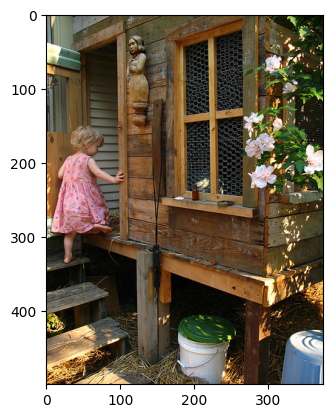

In [ ]:
### Sample Inference - Greedy
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg"
img = Image.open(img_path)
caption = inference_greedy(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,
                           img_path = img_path, id_to_word = id_to_word, transforms = get_transforms(), max_length = 40)

plt.imshow(img)

print(caption)

a brown dog is running on the sand


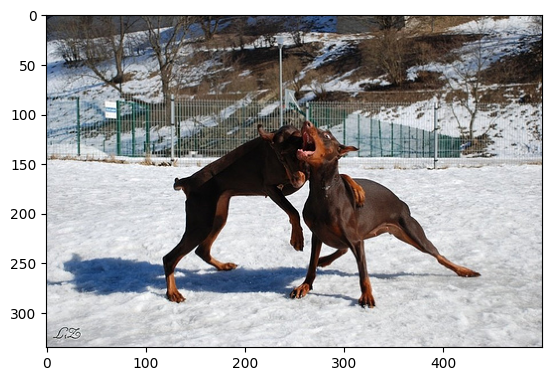

In [ ]:
### Sample Inference - Greedy
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/3385593926_d3e9c21170.jpg"
img = Image.open(img_path)
caption = inference_greedy(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,
                           img_path = img_path, id_to_word = id_to_word, transforms = get_transforms(), max_length = 40)

plt.imshow(img)

print(caption)

a brown dog is running through the water with a stick in its mouth
a brown dog is running through the water with a stick in his mouth
a brown dog is running through the water


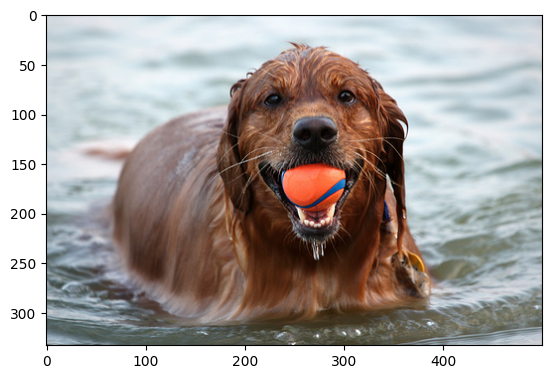

In [ ]:
### Sample Inference - Greedy
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/3048597471_5697538daf.jpg"
img = Image.open(img_path)
captions = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                           id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 10, no_of_op = 3)

plt.imshow(img)

for caption in captions:
    print(caption)

a little girl in a yellow dress is playing with a toy in the grass
a little girl in a red shirt and blue jeans is playing with a red toy
a little girl in a yellow shirt and blue jeans is playing with a red toy


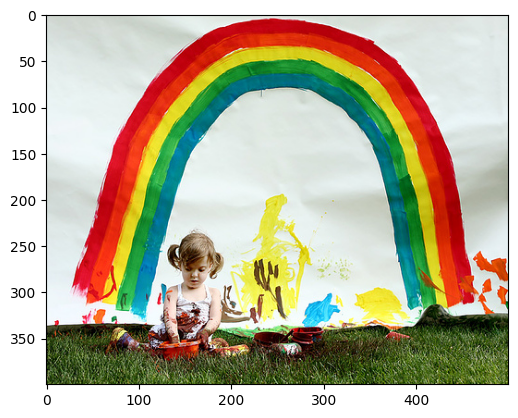

In [ ]:
### Sample Inference - Greedy
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg"
img = Image.open(img_path)
captions = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                           id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 10, no_of_op = 3)

plt.imshow(img)

for caption in captions:
    print(caption)

a black and white dog is running through the grass
a black and white dog is running through a grassy area
a black and white dog is running through a field of grass


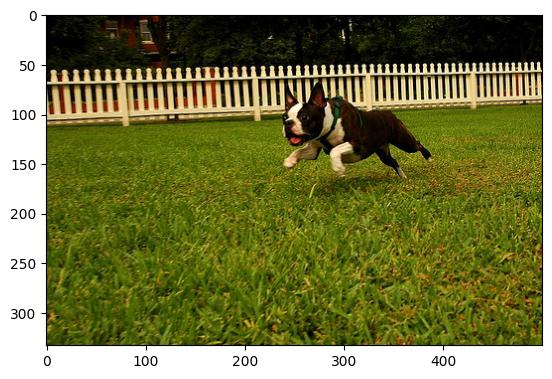

In [ ]:
### Sample Inference - Greedy
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/1009434119_febe49276a.jpg"
img = Image.open(img_path)
captions = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                           id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 10, no_of_op = 3)

plt.imshow(img)

for caption in captions:
    print(caption)

a little boy in a blue shirt is standing in front of a crowd of people
a little boy in a blue shirt is standing in front of a crowd
a little boy in a blue shirt is standing in front of a <unk>


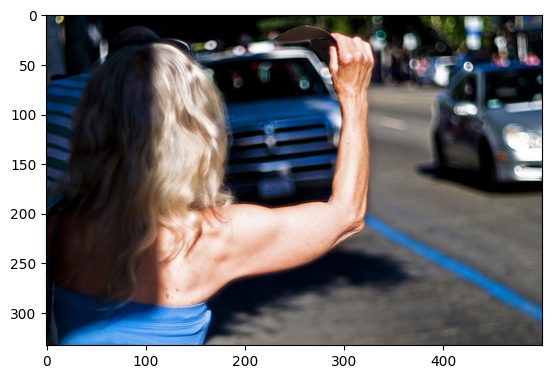

In [ ]:
### Sample Inference - Greedy
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/1056338697_4f7d7ce270.jpg"
img = Image.open(img_path)
captions = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                           id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 10, no_of_op = 3)

plt.imshow(img)

for caption in captions:
    print(caption)

a person is skiing down a snowy hill
a person is skiing down a snowy hill with a mountain in the background
a person is skiing down a snowy mountain


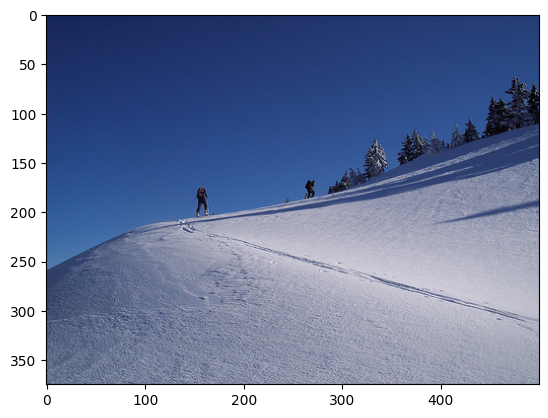

In [ ]:
### Sample Inference - Greedy
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/108899015_bf36131a57.jpg"
img = Image.open(img_path)
captions = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                           id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 10, no_of_op = 3)

plt.imshow(img)

for caption in captions:
    print(caption)

a little boy in a red shirt and blue jeans is sliding down a slide
a little boy in a red shirt and blue jeans is sliding down a red slide
a little boy in a red shirt and blue jeans is sliding down a blue slide


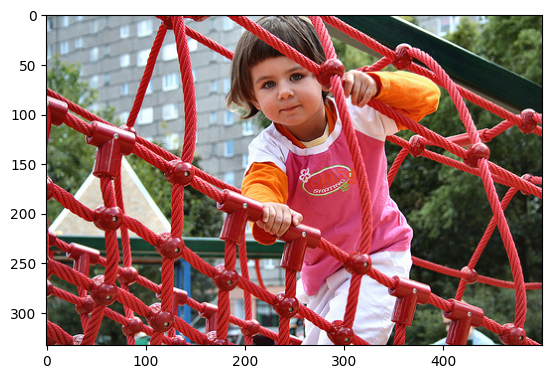

In [ ]:
### Sample Inference - Greedy
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/1007320043_627395c3d8.jpg"
img = Image.open(img_path)
captions = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                           id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 10, no_of_op = 3)

plt.imshow(img)

for caption in captions:
    print(caption)

a woman and a child are standing on a beach near a lake
a woman and a child are standing on a beach near the water
a woman and a child are standing on a beach near the ocean


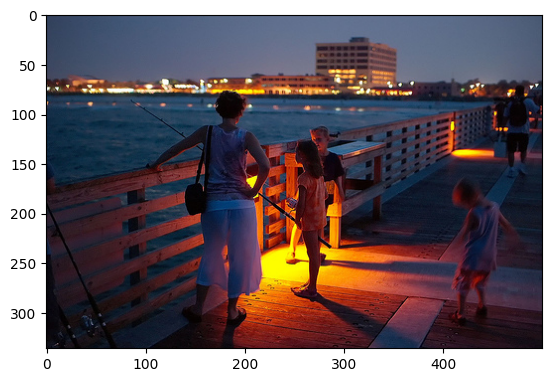

In [ ]:
### Sample Inference - Greedy
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/1089755335_0bfbfd30e6.jpg"
img = Image.open(img_path)
captions = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                           id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 10, no_of_op = 3)

plt.imshow(img)

for caption in captions:
    print(caption)

a black and white dog is running through a grassy field
a black and white dog is running through a field of grass
a black and white dog is running through a field


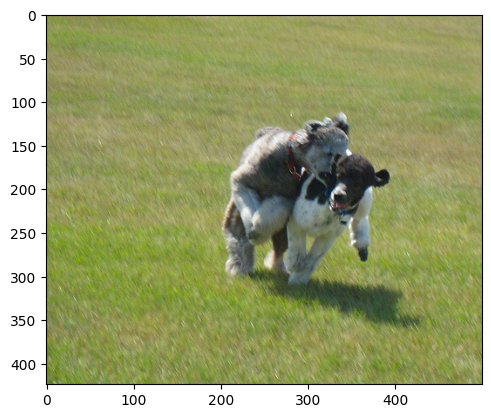

In [ ]:
### Sample Inference - Greedy
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/1164131282_b30926f332.jpg"
img = Image.open(img_path)
captions = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                           id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 10, no_of_op = 3)

plt.imshow(img)

for caption in captions:
    print(caption)

a boy jumps into a swimming pool
a boy jumps into a pool
a boy jumps into the pool


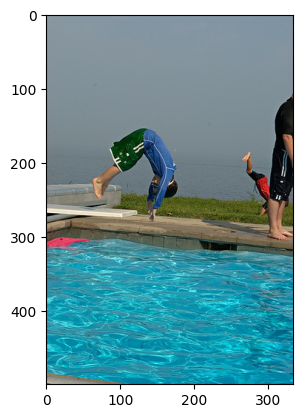

In [ ]:
### Sample Inference - Greedy
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/1236964638_1808784a3c.jpg"
img = Image.open(img_path)
captions = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                           id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 10, no_of_op = 3)

plt.imshow(img)

for caption in captions:
    print(caption)

a black dog is running through the water with a stick in its mouth
a black dog is running through the water
a black dog is running through the water with a stick in his mouth


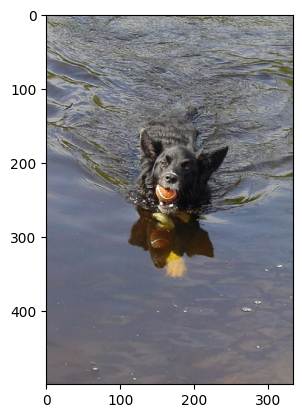

In [ ]:
### Sample Inference - Greedy
#img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/1248357227_2b4175fc39.jpg"
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/1306145560_1e37081b91.jpg"
img = Image.open(img_path)
captions = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                           id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 10, no_of_op = 3)

plt.imshow(img)

for caption in captions:
    print(caption)

a boy in a red shirt is jumping on a skateboard
a young boy wearing a red shirt is jumping on a skateboard
a young boy wearing a blue shirt is jumping on a skateboard


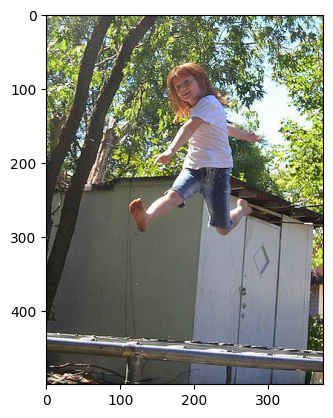

In [ ]:
### Sample Inference - Greedy
#img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/1248357227_2b4175fc39.jpg"
img_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset/1348304997_afe60a61df.jpg"
img = Image.open(img_path)
captions = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                           id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 10, no_of_op = 3)

plt.imshow(img)

for caption in captions:
    print(caption)

Bleu Score

In [ ]:
### Function to evaluate performance by Blue Score
def evaluate_bleu(test_path, imgs_path, models, id_to_word, transforms, max_length, beam_width):
    """
        Inputs:
                test_path: path to test.txt file containing img ids and gt captions
                imgs_path: path to dir where all images are stored
                models: (cnn, encoder, decoder) tuple containing all 3 req models
                id_to_word: reverse mapping of word vocabulary / word map
                transforms: transforms to apply on img
                max_length: maximum length allowrd for caption
                beam_width: top k to select
        Outputs:
                bleu score
    """
     #A dict containing img ids and list of gt captions : {'img_id' : []}
    img_caps = {}
    with open(test_path, "r") as file:

        #Iterate through each line to extract image names
        for line in file.readlines():

            #Get img id
            words = line.strip("\n")
            img_id = words.split()[0]
            caption = words.split()[1:]
            caption = preprocess_caption(" ".join(caption))
            #Append to dict
            if img_id in img_caps.keys():
                img_caps[img_id].append(caption)
            else:
                img_caps[img_id] = [caption]

    #Get Models
    cnn_model = models[0]
    nic_encoder = models[1]
    nic_decoder = models [2]

    #Lists to store bleu_score of each image
    b1_l = []; b2_l = []; b3_l = []; b4_l = [];
    #Find Bleu Score for each image
    for img, captions in tqdm(img_caps.items()):

        #For PriorityQueue Node error
        try:

            #Image path
            img_path = imgs_path + img + ".jpg"

            #Beam search to get top-1 caption
            caption = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                               id_to_word = id_to_word, transforms = transforms, max_length = max_length, beam_width = 10, no_of_op = 1)
            #Generate candidates and references for bleu_score function
            caption = preprocess_caption(caption)
            candidate = [caption]
            references = [captions]

            #Calculate Bleu Score
            b1 = bleu_score(candidate, references, weights=[1.0, 0, 0, 0])
            b2 = bleu_score(candidate, references, weights=[0.5, 0.5, 0, 0])
            b3 = bleu_score(candidate, references, weights=[0.33, 0.33, 0.33, 0])
            b4 = bleu_score(candidate, references, weights=[0.25, 0.25, 0.25, 0.25])
            #Append to lists
            b1_l.append(b1); b2_l.append(b2); b3_l.append(b3); b4_l.append(b4)

        except:
            continue

    #Calculate Avg
    b1_avg = np.mean(b1_l); b2_avg = np.mean(b2_l); b3_avg = np.mean(b3_l); b4_avg = np.mean(b4_l)

    return b1_avg, b2_avg, b3_avg, b4_avg

In [ ]:
### Set paths
test_path = "test.txt"
imgs_path = "/content/PICT/Flickr8k_Dataset/Flicker8k_Dataset"

### Evaluate
b1, b2, b3, b4 = evaluate_bleu(test_path = test_path, imgs_path = imgs_path, models = (inception_v3, nic_encoder, nic_decoder),
             id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 20)

print("B1 Score: ",b1)
print("B2 Score: ",b2)
print("B3 Score: ",b3)
print("B4 Score: ",b4)

100%|██████████| 1000/1000 [00:00<00:00, 43357.81it/s]

B1 Score:  nan
B2 Score:  nan
B3 Score:  nan
B4 Score:  nan
